In [ ]:
!git clone -q -b feature/demo https://github.com/avsthiago/deepbee-source.git
%cd deepbee-source/notebooks/

In [ ]:
!pip install -q -r ../requirements.txt

In [ ]:
# Download the dataset
!gdown 16BISStdoV0em-2-yBxceDxgHGDf65Ect -O data/raw/
!unzip -q data/raw/classification_dataset.zip -d data/raw/
!rm data/raw/classification_dataset.zip !rm -rf data/raw/_*

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard,
    ReduceLROnPlateau,
)
from tensorflow.keras.models import Model
import os
import time
import locale
from tensorflow.keras import backend as K

In [5]:
PATH = "data/raw/classification_dataset"
output_folder = "model/"
datasets = os.listdir(PATH)

size = 224
model_name = os.path.join(output_folder, f"mobilenet_{size}.keras")

tf.random.set_seed(42)

In [ ]:
# Create the model
input_tensor = Input(shape=(size, size, 3))
base_model = MobileNet(
    input_tensor=input_tensor, weights="imagenet", include_top=False
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(7, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [7]:
path_train = os.path.join(PATH, "train")
path_val = os.path.join(PATH, "validation")

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(path_train,
                                                    target_size=(size, size),
                                                    batch_size=50, shuffle=True)
val_generator = val_datagen.flow_from_directory(path_val,
                                                target_size=(size, size),
                                                batch_size=50, shuffle=True)

Found 2123 images belonging to 7 classes.
Found 551 images belonging to 7 classes.


In [8]:
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
earlystopper = EarlyStopping(patience=5, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_loss", patience=3, verbose=1, factor=0.5, min_lr=1e-6
)

In [ ]:
results = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,
    callbacks=[
        earlystopper,
        checkpointer,
        learning_rate_reduction,
    ],
)

## Validation

In [10]:
def deprocess_image(img):
    img = img.copy()
    # MobileNet preprocess_input scales input to [-1,1], reverse it
    img = (img + 1.0) * 127.5
    img = np.clip(img, 0, 255)
    return img.astype('uint8')

# Retrieve the Class Indices and Names
class_indices = train_generator.class_indices  # {'class_name': class_index}
indices_class = {v: k for k, v in class_indices.items()}  # {class_index: 'class_name'}

# Collect Samples
samples_per_class = {class_index: [] for class_index in indices_class.keys()}

for batch_index in range(len(val_generator)):
    x_batch, y_batch = val_generator[batch_index]
    y_batch_classes = np.argmax(y_batch, axis=1)
    for i in range(len(y_batch_classes)):
        class_index = y_batch_classes[i]
        if len(samples_per_class[class_index]) < 3:
            samples_per_class[class_index].append((x_batch[i], class_index))
    # Check if we have collected 3 samples for each class
    if all(len(samples) >= 3 for samples in samples_per_class.values()):
        break

# Prepare Data for Prediction
all_images = []
all_true_class_indices = []

for class_index, samples in samples_per_class.items():
    for img, true_class_index in samples:
        all_images.append(img)
        all_true_class_indices.append(true_class_index)

all_images = np.array(all_images)
all_true_class_indices = np.array(all_true_class_indices)

# Run predictions on all collected samples
preds = model.predict(all_images)
pred_class_indices = np.argmax(preds, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


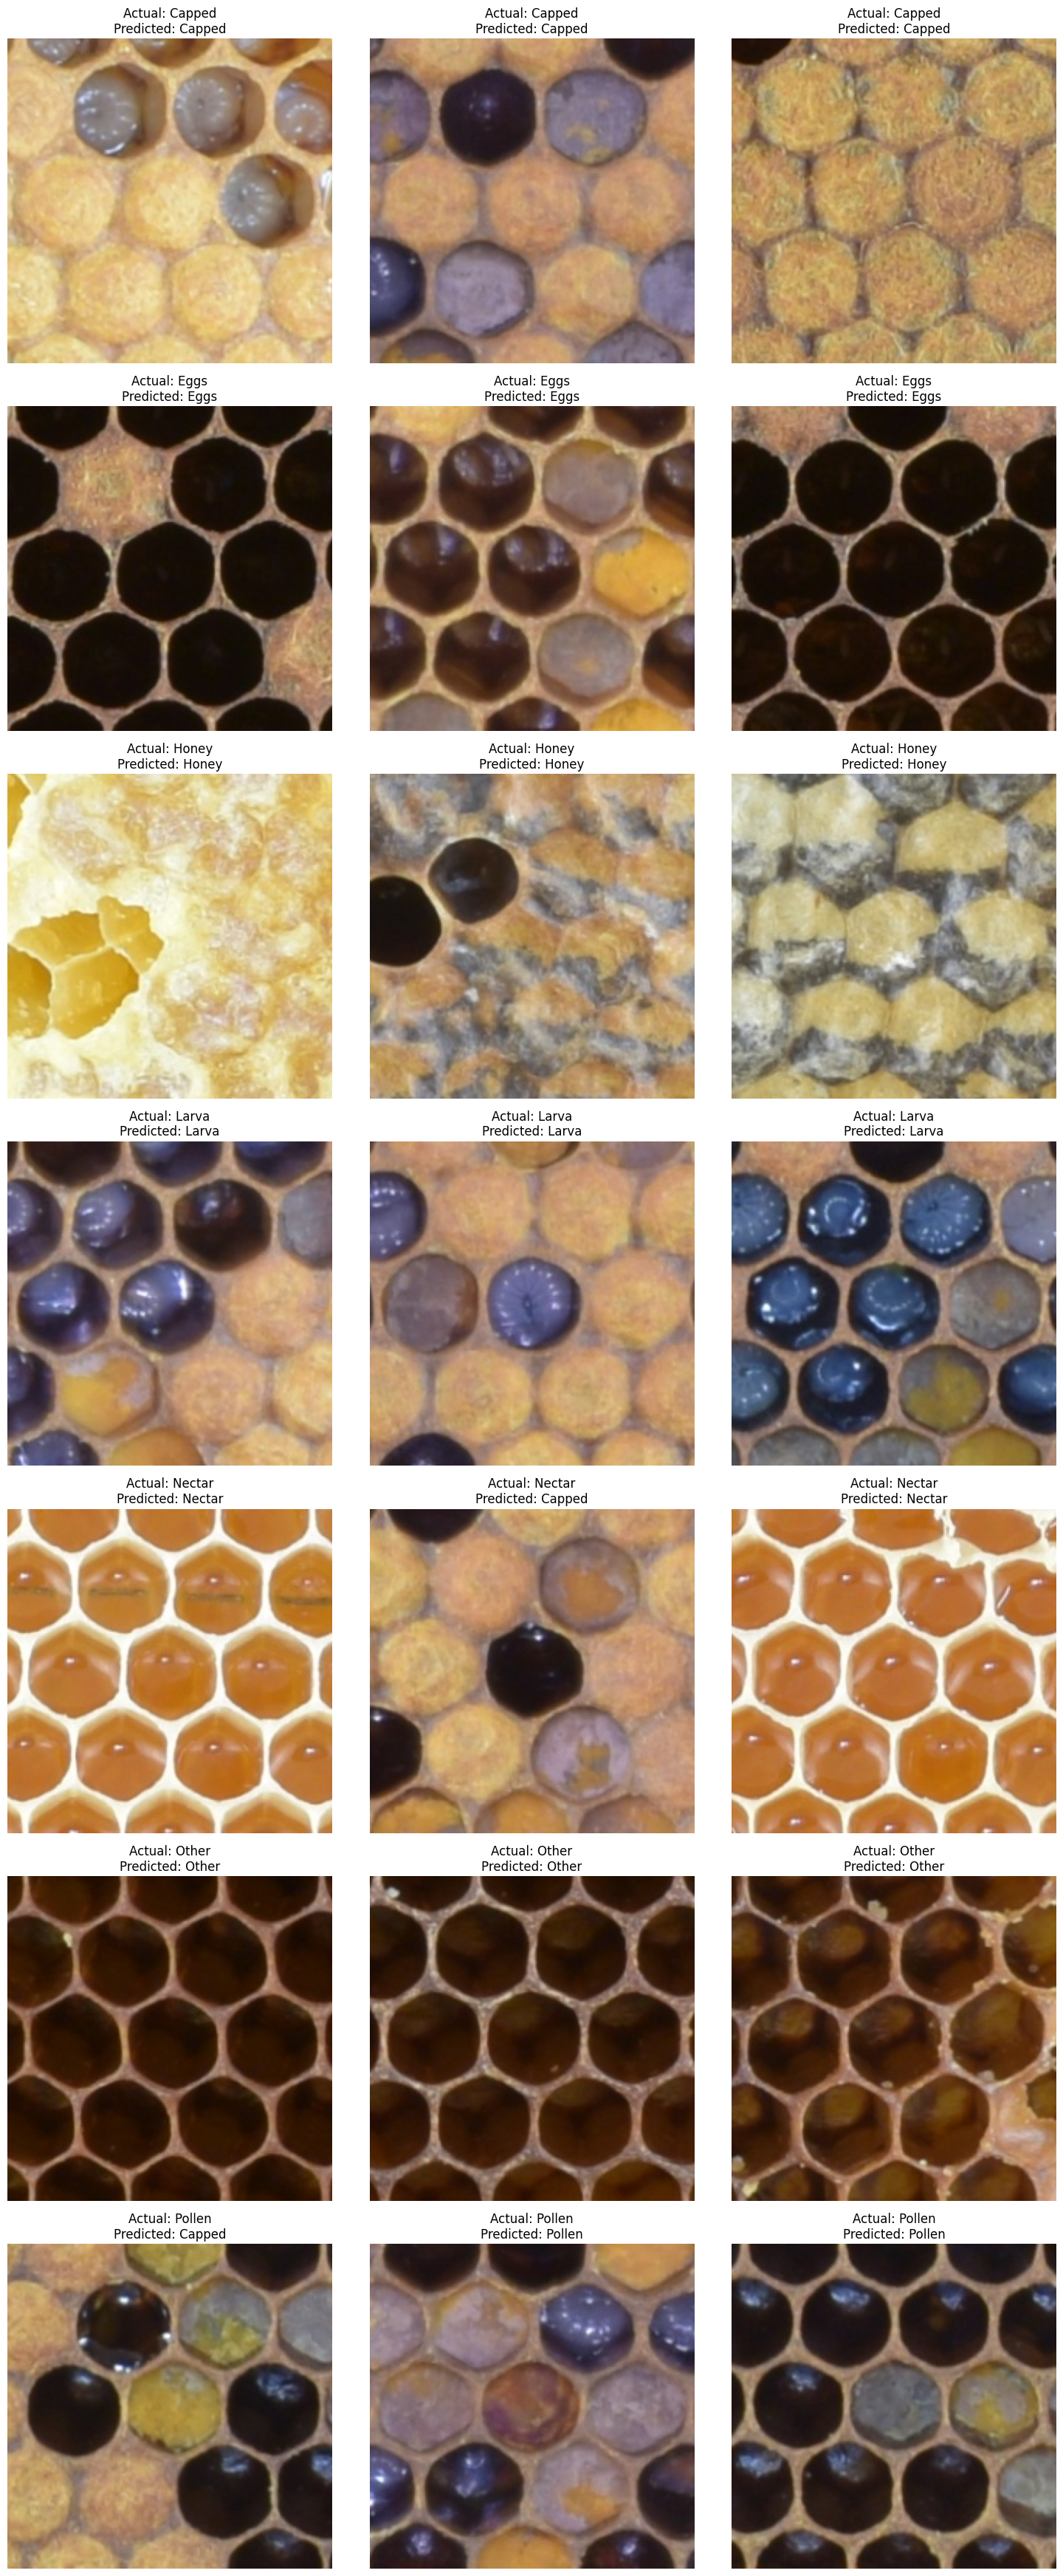

In [11]:
# Display Images
num_classes = len(indices_class)
fig, axs = plt.subplots(num_classes, 3, figsize=(15, 5 * num_classes))

index = 0
for class_row, class_index in enumerate(sorted(indices_class.keys())):
    class_name = indices_class[class_index]
    for i in range(3):
        img = all_images[index]
        true_class_index = all_true_class_indices[index]
        pred_class_index = pred_class_indices[index]
        pred_class_name = indices_class[pred_class_index]
        # Deprocess the image for display
        img_display = deprocess_image(img)
        # Plotting
        ax = axs[class_row, i] if num_classes > 1 else axs[i]
        ax.imshow(img_display)
        ax.axis('off')
        ax.set_title(
            f"Actual: {indices_class[true_class_index]}\nPredicted: {pred_class_name}"
        )
        index += 1

plt.tight_layout()
plt.show()